**Evaluating GOES images with coincident MODIS and ASTER**

What are the magnitude and distribution of differences between ABI-ASTER & MODIS-ASTER?
* Is there an East-to-West change in differences?
* Is there a North-to-South change in differences?
* Is there a relationship between differences and elevation, slope, or aspect?
* Is there a relationship between differences and fractional vegetation covered area?
* Is there a relationship between differences and fractional snow covered area? (from coincident MODIS)

In [3]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import xrspatial as xrs
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from asp_binder_utils import get_dem

In [4]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [5]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

In [226]:
def plot_regression_confidence_intervals(_x,_y,conf):

    # linear regression
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    
    # predict y values of origional data using the fit
    p_y = slope*_x + intercept
    
    # calculate the y-error (residuals)
    y_err = _y - p_y
    
    # create series of new test x-values to predict for
    p_x = np.arange(np.min(_x),np.max(_x)+1,1)
    
    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(_x)                 # mean of x
    n = _x.size                          # number of samples in original fit
    t = stats.t.ppf(conf, n-2)            # find the appropriate t value (for n-2, and two tailed 95%)        
    sse = np.sum(y_err**2)              # sum of the squares of the residuals
    st_err = np.sqrt(sse/(n-2))         # standard error
    
    sigma = st_err**2 * (1 + 1/n + ( ( n*(p_x-mean_x)**2 ) / ( n*np.sum(_x**2) - np.sum(_x)**2 ) ) )
    confs = t * np.sqrt(sigma)
    
    # now predict y based on test x-values
    p_y = slope*p_x + intercept
    
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - np.abs(confs)
    upper = p_y + np.abs(confs)
    
    # plot line of best fit
    c_x = np.array([_x.min(),_x.max()])
    c_y = slope*c_x + intercept
    plt.plot(c_x,c_y,'r--',label='Regression line')
    
    # plot confidence limits
    plt.plot(p_x,lower,':',c='grey',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,':',c='grey',label='Upper confidence limit (95%)')

In [11]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


---
Read in the ground based data timeseries for Gaylor Pit and CUES sites

In [6]:
# Gaylor Pit
tuol_df = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
tuol_df['timeUTC'] = tuol_df.index + pd.Timedelta(hours=8)
tuol_df.set_index('timeUTC',inplace=True)
tuol_ds = tuol_df.to_xarray().squeeze()

# CUES
cues_df = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_df['timeUTC'] = cues_df.index + pd.Timedelta(hours=8)
cues_df.set_index('timeUTC',inplace=True)
cues_ds = cues_df.to_xarray().squeeze()

Set up working area geometry

In [7]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find datasets

In [8]:
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')

Open all datasets

In [7]:
#ds = xr.open_mfdataset(filepaths, concat_dim='time', combine='nested')
#ds = ds.rio.clip(geometry)

Open my DEM, reproject to UTM, add to the dataset

In [8]:
#dem = xr.open_rasterio('dem/tuolumne_cues_dem.tif').rio.reproject_match(ds)
#ds['dem'] = dem.squeeze()

Compute slope and aspect and add to the dataset

In [9]:
#dem_array = rd.rdarray(ds.dem.values, no_data=np.nan).squeeze()
#slope = rd.TerrainAttribute(dem_array, attrib='slope_riserun')
#ds['slope'] = (['y','x'], slope)
#aspect = rd.TerrainAttribute(dem_array, attrib='aspect')
#ds['aspect'] = (['y','x'], aspect)
## aspect looks like it puts 0=360 at East not north. 

Open TCC and ad to the dataset

In [10]:
#tcc = xr.open_rasterio('data/NLCD_2016_Tree_Canopy_L48_20190831_2xOlzdukUemPqURl8ckP.tiff').rio.reproject_match(ds)
#ds['tcc'] = tcc.squeeze()
#fveg = (tcc - tcc.min()) / (tcc.max() - tcc.min()) # normalizing tcc to get fveg
#ds['fveg'] = fveg.squeeze()

In [11]:
#plt.figure()
#ds.ast_mod_mean_diff_tb.mean(axis=0).plot()
#
#plt.figure()
#ds.ast_goes_mean_diff_tb.mean(axis=0).plot()

In [12]:
#def fveg_mapZonalStats(zones, zonalstats, stat_name):
#    ''' Function for mapping the zonal statistics back to the original grid to get a 2D map of the chosen statistic'''
#    # create an empty array for this summary stat
#    zonal_stat = np.zeros_like(zones.values, dtype=np.float64)
#
#    # for each zone
#    for zone_n in zonalstats.index.values:
#        # get the summary stat for that zone, 
#        # and assign it to the correct locations in the zonal_stat array
#        #try:
#        zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)].loc[zone_n]
#        #except: #MaskError: Cannot convert masked element to a Python int.
#        #    zonal_stat[zones.values==zone_n] = -9999
#
#    # convert this to an xarray data array with the proper name
#    zonal_stat_da = xr.DataArray(zonal_stat, 
#                                 dims=["y", "x"],
#                                 coords=dict(
#                                             x=(["x"], zones.x),
#                                             y=(["y"], zones.y),
#                                             ),
#                                 name='zonal_{}'.format(stat_name))
#    # remove nodata values
#    zonal_stat_da = zonal_stat_da.where(zonal_stat_da!=-9999, np.nan)
#
#    return zonal_stat_da     

In [13]:
#da_fveg_mean_stack = []
#for i in range(0,len(ds.time)):
#    fveg_mean = ds.isel(time=i).groupby('ast_goes_goes_zones').mean().fveg.drop(['spatial_ref','band','time']).to_dataframe()
#    da_fveg_mean = fveg_mapZonalStats(ds.isel(time=i).ast_goes_goes_zones, fveg_mean, 'fveg')
#    da_fveg_mean_stack.append(da_fveg_mean)

In [14]:
#ds_fveg_mean = xr.concat(da_fveg_mean_stack, 'time' )

In [15]:
#ds['zonal_mean_fveg'] = ds_fveg_mean

In [16]:
#plt.figure(figsize=(6,5))
#ds.fveg.plot(cmap='Greens')
#plt.xlim((297250,308000))
#plt.ylim((4175000,4190000))
#plt.axis('off')
#plt.title('')

In [17]:
#plt.figure()
#ds.isel(time=10).ast_mod_mean_diff_tb.plot()
#
#plt.figure()
#ds.isel(time=10).ast_goes_mean_diff_tb.plot()
#
#plt.figure()
#ds.dem.plot()
#
#plt.figure()
#ds.slope.plot()
#
#plt.figure()
#ds.aspect.plot()
#
#plt.figure()
#ds.fveg.plot()
#
#plt.figure()
#ds.isel(time=10).zonal_mean_fveg.plot()

In [18]:
#ds.to_netcdf('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_orthorectified.nc')

In [9]:
ds = xr.open_dataset('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_orthorectified.nc')

In [10]:
ds

<xarray.Dataset>
Dimensions:                 (time: 27, x: 499, y: 500)
Coordinates:
  * time                    (time) datetime64[ns] 2017-04-21T18:51:07 ... 2020-04-13T18:51:17
  * y                       (y) float64 4.16e+06 4.16e+06 ... 4.205e+06
  * x                       (x) float64 2.826e+05 2.827e+05 ... 3.274e+05
    band                    int64 ...
    spatial_ref             int64 ...
Data variables:
    ast_goes_aster_rad      (time, y, x) float64 ...
    ast_goes_goes_rad       (time, y, x) float32 ...
    ast_goes_goes_tb        (time, y, x) float32 ...
    ast_goes_goes_zones     (time, y, x) float64 ...
    ast_goes_mean_rad       (time, y, x) float64 ...
    ast_goes_max_rad        (time, y, x) float64 ...
    ast_goes_min_rad        (time, y, x) float64 ...
    ast_goes_std_rad        (time, y, x) float64 ...
    ast_goes_var_rad        (time, y, x) float64 ...
    ast_goes_zonal_count    (time, y, x) float64 ...
    ast_goes_mean_diff_rad  (time, y, x) float64 ...


---
---

### Elevation

30.149597431219846 3002.0099376362755 0.26443505147335983 0.0 0.07723577400224746
11.769173218979331 2986.4832627201663 0.09025647756854666 0.0 0.09121969776721225
-13.594070486206986 3021.1939520162505 -0.08270204118476616 0.0 0.11506419695679086


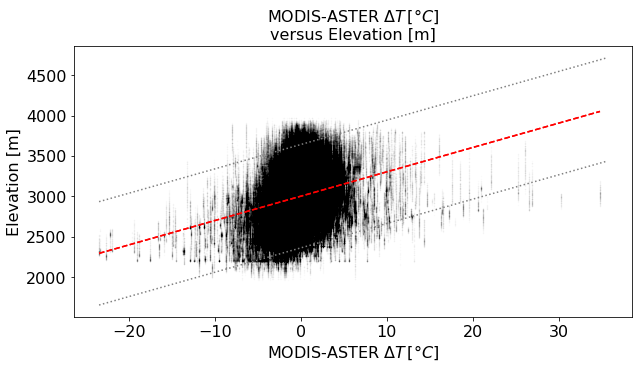

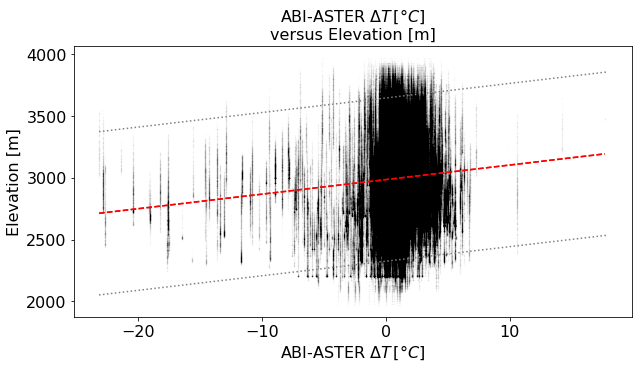

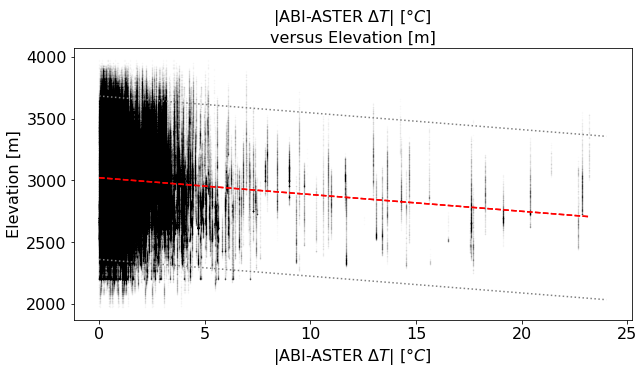

In [227]:
conf = 0.975

y = np.array([ds.dem.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(10,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=1)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
print(slope, intercept, r, p, se)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')
plot_regression_confidence_intervals(_x,_y,conf)

# ABI-ASTER deltaT
plt.figure(figsize=(10,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=1)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
print(slope, intercept, r, p, se)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')
plot_regression_confidence_intervals(_x,_y,conf)

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(10,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=1)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
print(slope, intercept, r, p, se)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Elevation [m]')
plot_regression_confidence_intervals(_x,_y,conf)

94.26867475435817 2998.9707131870264 0.46652728952048866 0.0 0.5055219239954033
114.9936074839456 2885.9717938225353 0.2879804515411571 0.0 1.0815827508383646
120.6561006022742 2857.776764809806 0.2156483841108917 0.0 1.545293335364602


Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Elevation [m]')

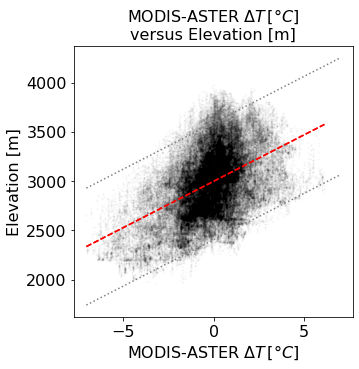

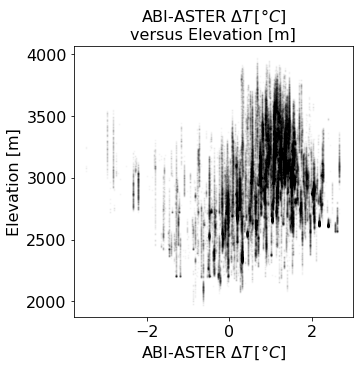

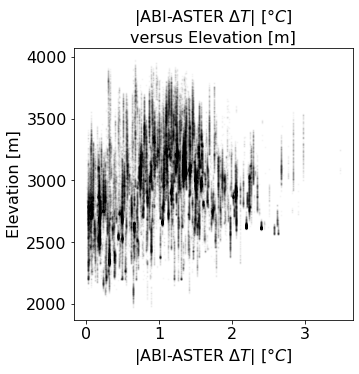

In [231]:
conf = 0.975

y = ds.dem.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=5)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
print(slope, intercept, r, p, se)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')
plot_regression_confidence_intervals(_x,_y,conf)

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=5)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
print(slope, intercept, r, p, se)
#plt.plot(np.linspace(_x.min(),_x.max()),
#         slope*np.linspace(_x.min(),_x.max())+intercept,
#         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')
#plot_regression_confidence_intervals(_x,_y,conf)

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=5)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
print(slope, intercept, r, p, se)
#plt.plot(np.linspace(_x.min(),_x.max()),
#         slope*np.linspace(_x.min(),_x.max())+intercept,
#         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Elevation [m]')
#plot_regression_confidence_intervals(_x,_y,conf)

### Slope

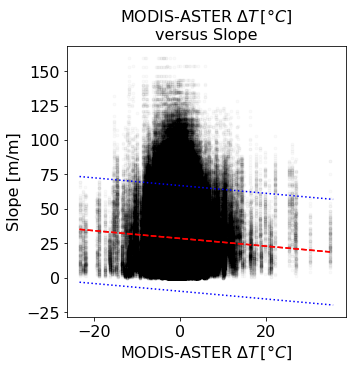

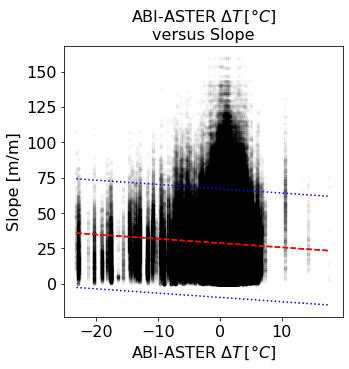

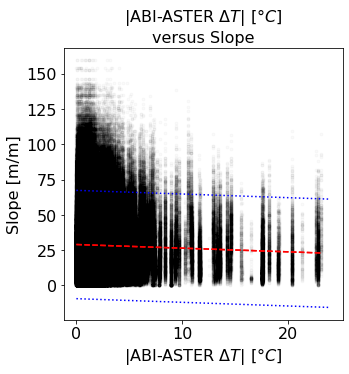

In [37]:
conf = 0.975

y = np.array([ds.slope.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Slope')
plot_regression_confidence_intervals(_x,_y,conf)

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Slope')
plot_regression_confidence_intervals(_x,_y,conf)

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Slope')
plot_regression_confidence_intervals(_x,_y,conf)

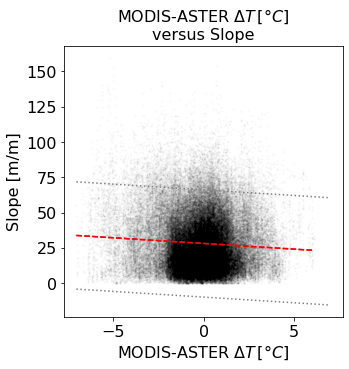

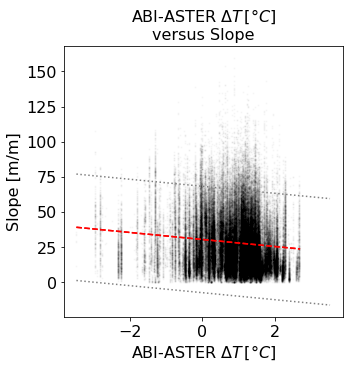

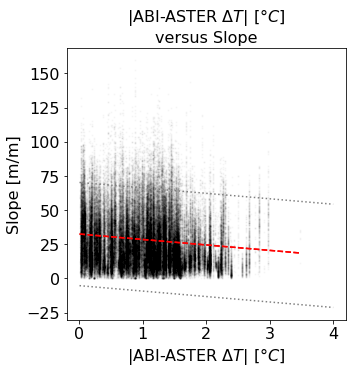

In [229]:
y = ds.slope.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=5)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Slope')
plot_regression_confidence_intervals(_x,_y,conf)

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=5)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Slope')
plot_regression_confidence_intervals(_x,_y,conf)

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=5)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Slope')
plot_regression_confidence_intervals(_x,_y,conf)

---
---
---

# download another dem

In [46]:
ds.dem

<xarray.DataArray 'dem' (y: 500, x: 499)>
array([[2482., 2468., 2462., ..., 3467., 3549., 3529.],
       [2492., 2474., 2471., ..., 3478., 3541., 3527.],
       [2498., 2492., 2482., ..., 3493., 3531., 3521.],
       ...,
       [2822., 2840., 2849., ..., 1948., 1948., 1948.],
       [2876., 2874., 2866., ..., 1948., 1948., 1948.],
       [2930., 2920., 2901., ..., 1948., 1948., 1948.]], dtype=float32)
Coordinates:
  * y            (y) float64 4.16e+06 4.16e+06 4.16e+06 ... 4.205e+06 4.205e+06
  * x            (x) float64 2.826e+05 2.827e+05 ... 3.273e+05 3.274e+05
    band         int64 ...
    spatial_ref  int64 ...
Attributes:
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [79]:
get_dem(demtype='SRTMGL3', 
        bounds=(-120, 36 , -118, 40), 
        out_fn='dem_3.tif')

https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&west=-120&south=36&east=-118&north=40&outputFormat=GTiff


'dem_3.tif'

In [85]:
dem_elevation = rxr.open_rasterio('dem_3.tif')
dem_elevation = dem_elevation.rio.reproject_match(ds.dem)

In [80]:
!gdaldem aspect dem_3.tif aspect_3.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [111]:
dem_aspect = rxr.open_rasterio('aspect_3.tif')
dem_aspect = dem_aspect.rio.reproject_match(ds.dem)
dem_aspect = dem_aspect.where(dem_aspect != -9999)

In [88]:
!gdaldem slope dem_3.tif slope_3.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [108]:
dem_slope = rxr.open_rasterio('slope_3.tif')
dem_slope = dem_slope.rio.reproject_match(ds.dem)
#dem_slope = dem_slope.where(dem_slope != -9999)
#dem_slope = dem_slope.where(dem_slope != 0)

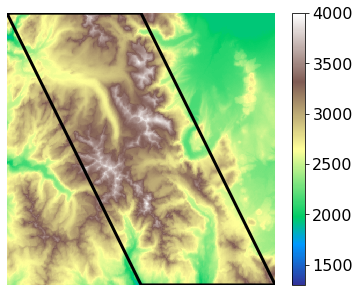

In [216]:
fig, ax = plt.subplots(figsize=(6,5))
dem_elevation.plot(ax=ax, vmin=1300, vmax=4000, cmap='terrain')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='-', color='k', lw=3)

---

### Aspect

(0.0, 6.283185307179586, 0.0, 1.0550000000000004)

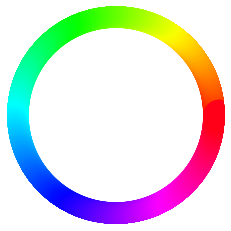

In [203]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

xval = np.arange(0, 2*np.pi, 0.01)
yval = np.ones_like(xval)

colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(0.0, 2*np.pi)

ax = plt.subplot(1,1,1, polar=True)
ax.scatter(xval, yval, c=xval, s=1000, cmap=colormap, norm=norm, linewidths=0)
#ax.set_yticks([])
ax.axis('off')

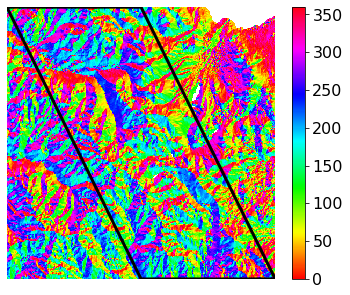

In [215]:
fig, ax = plt.subplots(figsize=(6,5))
dem_aspect.plot(ax=ax, cmap='hsv')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='-', color='k', lw=3)

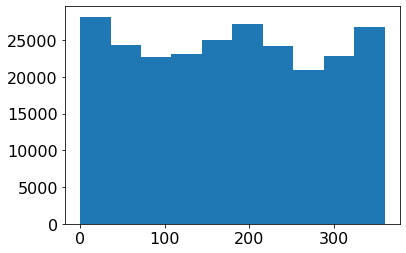

In [146]:
plt.hist(dem_aspect.values.ravel());

In [113]:
ds_day = ds.where(ds.time.dt.hour==18)
ds_night = ds.where(ds.time.dt.hour==6)

In [114]:
def pol2cart(rho, phi, rotate):
    # given a point's polar coordinates rho (radial distance), phi (clockwise azimuth angle), 
    # and rotate (angle to add to phi to put 0 degrees at the top like a compass)
    #https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
    x = rho * np.cos(np.radians(-phi+rotate))
    y = rho * np.sin(np.radians(-phi+rotate))
    return(x, y)

In [115]:
ds_day = ds.where(ds.time.dt.hour==18, drop=True)
ds_night = ds.where(ds.time.dt.hour==6, drop=True)

In [169]:
azis_all = np.array([dem_aspect.values]*len(ds.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
azis_day = np.array([dem_aspect.values]*len(ds_day.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
azis_night = np.array([dem_aspect.values]*len(ds_night.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
temps_day = ds_day.ast_goes_mean_diff_tb.values.ravel() # ABI temperatures day
temps_night = ds_night.ast_goes_mean_diff_tb.values.ravel() # ABI temperatures night
#temps_day = ds_day.ast_mod_mean_diff_tb.values.ravel() # MODIS temperatures day
#temps_night = ds_night.ast_mod_mean_diff_tb.values.ravel() # MODIS temperatures night

rotate = 90 # rotate 90 for 0 at top, rotate -90 for 0 at bottom 

# for all data
x_day,y_day = pol2cart(temps_day,azis_day,rotate)
x_night,y_night = pol2cart(temps_night,azis_night,rotate) 

# average by 1 degree bins
azis_day_1deg = np.round(azis_day,0)
azis_night_1deg = np.round(azis_night,0)
azis_all_1deg = np.round(azis_all,0)
temps_day_1deg = []
temps_night_1deg = []
counts_1deg = []
for a in range(0,360):
    temps_day_1deg.append(np.nanmean(temps_day[azis_day_1deg == a]))
    temps_night_1deg.append(np.nanmean(temps_night[azis_night_1deg == a]))
    counts_1deg.append(len(azis_all_1deg[azis_all_1deg == a]))

x_day_1deg,y_day_1deg = pol2cart(temps_day_1deg,np.array(range(0,360)),rotate) 
x_night_1deg,y_night_1deg = pol2cart(temps_night_1deg,np.array(range(0,360)),rotate)
x_counts, y_counts = pol2cart(counts_1deg,np.array(range(0,360)),rotate)

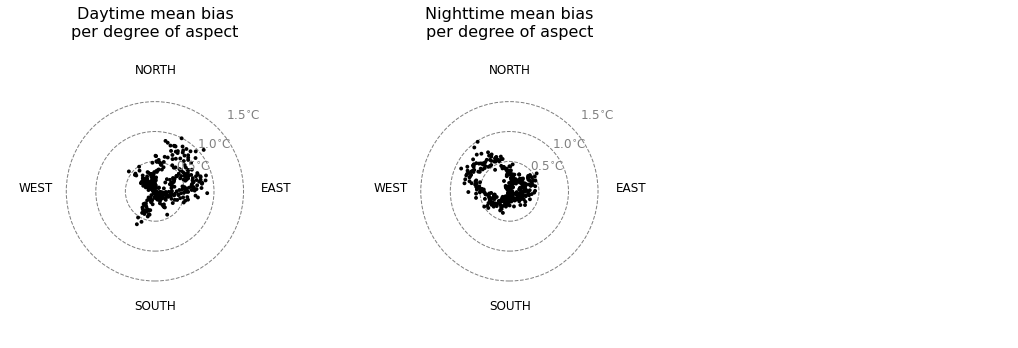

In [171]:





fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize=(18,5.5))



for each_ax in [ax, ax2]:
    each_ax.plot(0,0,'x',color='grey')
    circle0p5 = plt.Circle((0, 0), radius=0.5, color='grey', fill=False, linestyle='--')
    circle1 = plt.Circle((0, 0), radius=1, color='grey', fill=False, linestyle='--')
    circle1p5 = plt.Circle((0, 0), radius=1.5, color='grey', fill=False, linestyle='--')
    each_ax.add_artist(circle0p5)
    each_ax.add_artist(circle1)
    each_ax.add_artist(circle1p5)


    # SOUTH should be 180
    x_south,y_south = pol2cart(2,190,rotate)
    each_ax.text(x_south,y_south,'SOUTH',fontsize=12)
    
    # EAST should be 90
    x_east,y_east = pol2cart(1.8,90,rotate)
    each_ax.text(x_east,y_east,'EAST',fontsize=12)
    
    # NORTH should be 0
    x_north,y_north = pol2cart(2,350,rotate)
    each_ax.text(x_north,y_north,'NORTH',fontsize=12)
    
    # WEST should be 270
    x_west,y_west = pol2cart(2.3,270,rotate)
    each_ax.text(x_west,y_west ,'WEST',fontsize=12)

    each_ax.text(.35,.35,'0.5$^{\circ}$C',color='grey',fontsize=12)
    each_ax.text(.72,.72,'1.0$^{\circ}$C',color='grey',fontsize=12)
    each_ax.text(1.2,1.2,'1.5$^{\circ}$C',color='grey',fontsize=12)



# DAY
#ax.scatter(x,y,s=5,alpha=0.3,facecolors='tab:gray', edgecolors='none',label='Temperature per 1$^{\circ}$ azimuth bin');
ax.scatter(x_day_1deg,y_day_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
#ax.plot(x_1deg,y_1deg,markersize=10,alpha=1, linestyle='-',c='r', zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax.set_title('Daytime mean bias\nper degree of aspect')

# NIGHT
ax2.scatter(x_night_1deg,y_night_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax2.set_title('Nighttime')
ax2.set_title('Nighttime mean bias\nper degree of aspect')

# HISTOGRAM (sort of) of AZIMUTHS
#ax3.scatter(x_counts,y_counts,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax3.axis('off')

for each_ax in [ax, ax2]:
    each_ax.set_xlim((-2.5,2.5))
    each_ax.set_ylim((-2.5,2.5))
    each_ax.axis('off')
    # Direction of GOES-16's view is about 122 degrees (when north is 0), but here with south as 0, that is 180+122 = 302
    pointer_loc = 1.9
    length = .3
    sun_x, sun_y = pol2cart(pointer_loc+length,122,rotate)
    sun_x2, sun_y2 = pol2cart(pointer_loc,122,rotate)
    each_ax.quiver(sun_x2,sun_y2,-sun_x2,-sun_y2,color='grey',label='GOES-16 ABI')
    each_ax.plot([sun_x,sun_x2],[sun_y,sun_y2],'-',linewidth='2',color='grey')
    each_ax.text(sun_x+.1, sun_y-.2,'GOES-16 View',fontsize=15,color='grey')

#plt.legend(loc='lower right')
plt.savefig('images/mean_bias_per_degree_aspect_day_night_ASTER-ABI.png',dpi=200)




### Fveg (zeros removed)

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

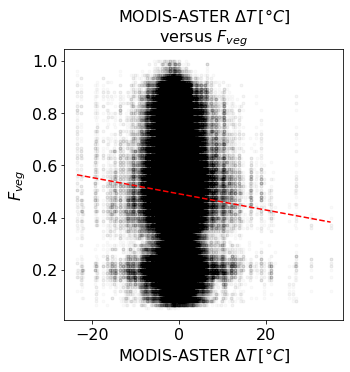

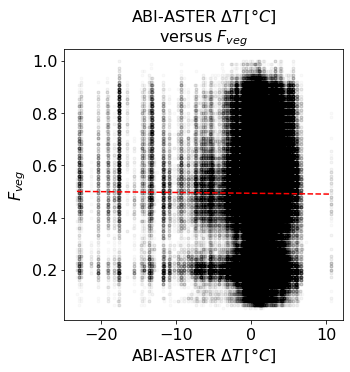

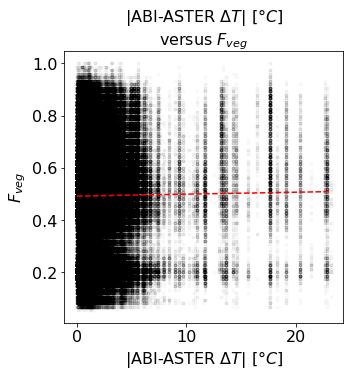

In [217]:
y = np.array([ds.fveg.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

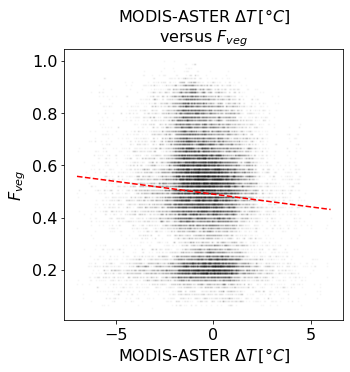

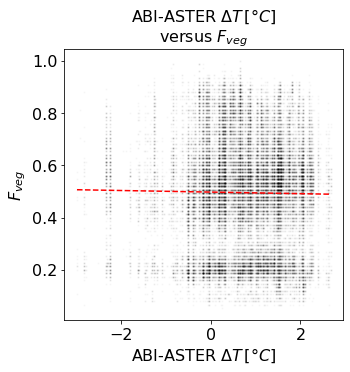

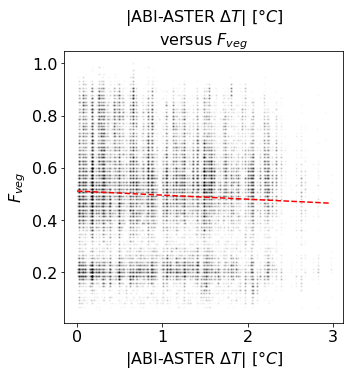

In [325]:
y = ds.fveg.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02,s=5)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02,s=5)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02,s=5)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

### Zonal mean fveg

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

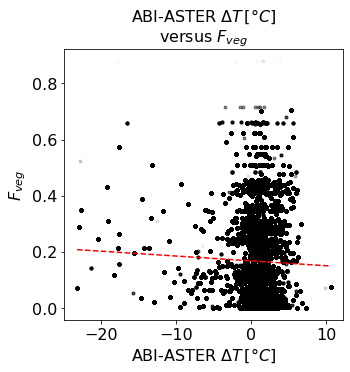

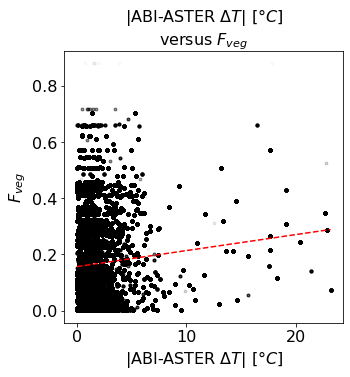

In [219]:
y = ds.zonal_mean_fveg.values.ravel()

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

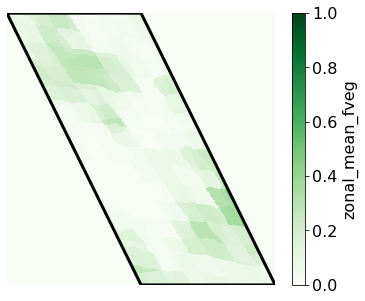

In [327]:
fig, ax = plt.subplots(figsize=(6,5))
ds.zonal_mean_fveg.mean(axis=0).plot(ax=ax, cmap='Greens',vmin=0,vmax=1)
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='-', color='k', lw=3)

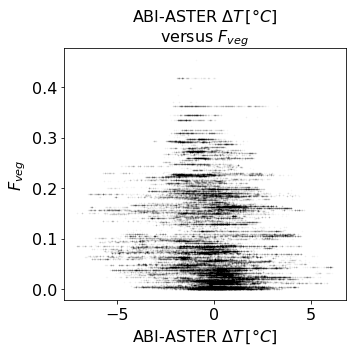

In [328]:
y = ds.zonal_mean_fveg.mean(axis=0).values.ravel()



# ABI-ASTER deltaT
plt.figure(figsize=(5,5), tight_layout=True)
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='o',c='k',alpha=0.02, s=1)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
#plt.plot(np.linspace(_x.min(),_x.max()),
#         slope*np.linspace(_x.min(),_x.max())+intercept,
#         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')
plt.savefig('images/fveg-vs-deltaT.png',dpi=200)


## Absolute value of ABI-ASTER deltaT
#plt.figure(figsize=(5,5))
#x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
#x0 = x[y!=0]
#y0 = y[y!=0]
#plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
#_x = x0[~np.isnan(x0)]
#_y = y0[~np.isnan(x0)]
#slope, intercept, r, p, se = stats.linregress(_x, _y)
#plt.plot(np.linspace(_x.min(),_x.max()),
#         slope*np.linspace(_x.min(),_x.max())+intercept,
#         '--r',zorder=99)
#plt.ylabel('$F_{veg}$')
#plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
#plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

---
---

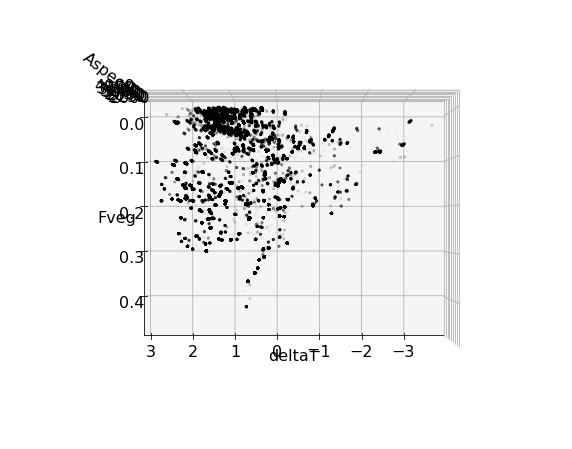

In [306]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import random

# dummy variables for demonstration
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
y = ds.zonal_mean_fveg.mean(axis=0).values.ravel()
z = dem_elevation.values.ravel()

# build the figure instance
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='k', marker='.', alpha=0.02)

# set your labels
ax.set_xlabel('deltaT')
ax.set_ylabel('Fveg')
ax.set_zlabel('Aspect')

a = 90
ax.view_init(a,a)

plt.show()

---
---